## 4.1 Logistic Regression

Import necessary libraries to perform logistic regression.

In [1]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
from scipy.sparse import csr_matrix, vstack, hstack
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from joblib import load

### 1. Data Prep for ML

Unpickle data and remove any NA values.

Concate "comment" and "parent_comment" for TF-IDF and BoW from training and testing datasets using vstack.

In [2]:
train = pd.read_pickle("data/train.pkl")
test = pd.read_pickle("data/test.pkl")
tfidf_vec = load('tdvectorizer.pkl')

In [3]:
train_parent_tfidf_csr = vstack(train["parent_comment_tfidf"])
test_parent_tfidf_csr = vstack(test["parent_comment_tfidf"])

train_tfidf_csr = vstack(train["comment_tfidf"])
test_tfidf_csr = vstack(test["comment_tfidf"])

train_parent_bow_csr = vstack(train["parent_comment_bow"])
test_parent_bow_csr = vstack(test["parent_comment_bow"])

train_bow_csr = vstack(train["comment_bow"])
test_bow_csr = vstack(test["comment_bow"])

In [4]:
train.columns

Index(['comment', 'parent_comment', 'comment_tokens', 'parent_comment_tokens',
       'comment_score', 'parent_comment_score',
       'weighted_parent_sentiment_score_neutral',
       'weighted_parent_sentiment_score_positive',
       'weighted_comment_sentiment_score_neutral',
       'weighted_comment_sentiment_score_positive', 'comment_word_count',
       'parent_comment_word_count', 'comment_token_count',
       'parent_comment_token_count', 'comment_unique_word_count',
       'parent_comment_unique_word_count', 'comment_unique_token_count',
       'parent_comment_unique_token_count', 'comment_stopword_count',
       'parent_comment_stopword_count', 'comment_mean_word_length',
       'parent_comment_mean_word_length', 'comment_mean_token_length',
       'parent_comment_mean_token_length', 'comment_char_count',
       'parent_comment_char_count', 'comment_punctuation_count',
       'parent_comment_punctuation_count', 'comment_hashtag_count',
       'parent_comment_hashtag_count', 'co

List of features necessary for logistic regression.

In [5]:
list_of_features = [
       'comment_word_count','parent_comment_word_count',
       'comment_token_count', 'parent_comment_token_count',
       'comment_unique_word_count', 'parent_comment_unique_word_count',
       'comment_unique_token_count', 'parent_comment_unique_token_count',
       'comment_stopword_count', 'parent_comment_stopword_count',
       'comment_mean_word_length', 'parent_comment_mean_word_length',
       'comment_mean_token_length', 'parent_comment_mean_token_length',
       'comment_char_count', 'parent_comment_char_count',
       'comment_punctuation_count', 'parent_comment_punctuation_count',
       'comment_hashtag_count', 'parent_comment_hashtag_count',
       'comment_number_count', 'parent_comment_number_count',
       'weighted_parent_sentiment_score_neutral',
       'weighted_parent_sentiment_score_positive',
       'weighted_comment_sentiment_score_neutral',
       'weighted_comment_sentiment_score_positive']

Here we will standardize columns with boolean values. We will change from boolean to integer type and convert the features from a dense matrix to a sparse matrix using the function csr_matrix. We use MaxAbsScaler() to scale all data down to between -1 and 1 for easy analysis.

In [6]:
bool_cols = ['weighted_parent_sentiment_score_neutral',
             'weighted_parent_sentiment_score_positive',
             'weighted_comment_sentiment_score_neutral',
             'weighted_comment_sentiment_score_positive']

for col in bool_cols: #need to convert bool type to integer
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)

X_train_gen_features = csr_matrix(train[list_of_features])

#Scaling Non-BoW/tfidf Features
X_train_scaler = MaxAbsScaler()
X_train_gen_features = X_train_scaler.fit_transform(X_train_gen_features)

X_test_gen_features = csr_matrix(test[list_of_features])
X_test_gen_features = X_train_scaler.transform(X_test_gen_features)

y_train_LR = train['label']
y_test_LR = test['label']

### 2. Finidng Best Combination of Features

#### Baseline 1: General Features

Performing Logistic Regression using general features as the baseline.

We will first train the training data using the LogisticRegression() model. We will then make predictions and compare the actual values and predicted values using the mean and stardard deviation of the area under the ROC curve. By looking at the difference in the area under curve measurements we can evaluate the accuracy and precision of logistic regression for this dataset.

In [7]:
#Data Specific Prep
X_train_LR = X_train_gen_features

In [8]:
k = 5

model = LogisticRegression(max_iter = 10000)
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")

Mean roc_auc: 0.5423398395843808
Standard Deviation of roc_auc: 0.0016556102382697887


#### Baseline 2: Comment BoW

Performing Logistic Regression using Comment Bag of Words as the baseline.

In [9]:
#Data Specific Prep
X_train_LR = train_bow_csr

In [10]:
k = 5

model = LogisticRegression(max_iter = 10000)
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
#unigram only: Mean roc_auc: 0.655919472075098
#unigram only: Standard Deviation of roc_auc: 0.0008334994867002629
print(f"Standard Deviation of roc_auc: {std_roc_auc}")

Mean roc_auc: 0.672263227136665
Standard Deviation of roc_auc: 0.0007143885012562422


#### Baseline 3: Comment TF-IDF

Performing Logistic Regression using Comment TF-IDF as the baseline.

In [11]:
#Data Specific Prep
X_train_LR = train_tfidf_csr

In [12]:
k = 5

model = LogisticRegression(max_iter = 100000)
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")
#unigram only: Mean roc_auc: 0.6592838234414328
#unigram only: Standard Deviation of roc_auc: 0.0009248592313210024

Mean roc_auc: 0.6789695072512285
Standard Deviation of roc_auc: 0.0015081274346395376


#### Baseline 4: General Features + BoW

Performing Logistic Regression using both General Features and Comment Bag of Words as the baseline.

In [13]:
X_train_LR = hstack([X_train_gen_features,train_bow_csr])

In [14]:
k = 5

model = LogisticRegression(max_iter = 100000)
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")
#unigram: Mean roc_auc: 0.6578548281567246
#unigram: Standard Deviation of roc_auc: 0.0015689875036237729

Mean roc_auc: 0.6742836327408219
Standard Deviation of roc_auc: 0.0007569169877033473


#### Baseline 5: General Features + TF-IDF

Performing Logistic Regression using both General Features and TF-IDF as the baseline.

In [15]:
X_train_LR = hstack([X_train_gen_features,train_tfidf_csr])

In [16]:
k = 5

model = LogisticRegression(max_iter = 100000)
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")
#unigram: Mean roc_auc: 0.6623742530514969
#unigram: Standard Deviation of roc_auc: 0.0010939794906847484

Mean roc_auc: 0.6804444827488695
Standard Deviation of roc_auc: 0.0015607021963323514


#### Baseline 6: General Features + Comment TF-IDF + Parent TF-IDF

Performing Logistic Regression using General Features, Comment TF-IDF and Parent comment TF-IDF as the baseline.

In [17]:
X_train_LR = hstack([X_train_gen_features,train_tfidf_csr,train_parent_tfidf_csr])

In [18]:
k = 5

model = LogisticRegression(max_iter = 100000)
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")
#unigram: Mean roc_auc: 0.6595766552618814
#unigram: Standard Deviation of roc_auc: 0.0020504330756799696

Mean roc_auc: 0.6761643882235888
Standard Deviation of roc_auc: 0.0013496823304547626


#### Baseline 7: General Features + Parent TFIDF

Performing Logistic Regression using both General Features and Parent comment TF-IDF as the baseline.

In [19]:
X_train_LR = hstack([X_train_gen_features,train_parent_tfidf_csr])

In [20]:
k = 5

model = LogisticRegression(max_iter = 100000)
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")
#unigram: Mean roc_auc: 0.570165520029702
#unigram: Standard Deviation of roc_auc: 0.002821502726381473

Mean roc_auc: 0.5735754038329169
Standard Deviation of roc_auc: 0.0019966844421729496


Best Training Done with General Features and comment TD-IDF as features

### 3. Base Model
Using Baseline 5: General Features + TF-IDF

In [21]:
X_train_LR = hstack([X_train_gen_features,train_tfidf_csr])

Running 5-fold Cross Validation

In [22]:
k = 5

model = LogisticRegression(max_iter = 100000)
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")
#unigram: Mean roc_auc: 0.6623742530514969
#unigram: Standard Deviation of roc_auc: 0.0010939794906847484

Mean roc_auc: 0.6804444827488695
Standard Deviation of roc_auc: 0.0015607021963323514


Evaluating Base Model on Test Set

In [44]:
# Train Baseline Model on whole training set
model = LogisticRegression(max_iter = 100000)
model.fit(X_train_LR, y_train_LR)

# Evaluate AUC_ROC
X_test_LR = hstack([X_test_gen_features,test_tfidf_csr])
y_pred_test = model.predict(X_test_LR)
roc_auc_test = roc_auc_score(y_test_LR, y_pred_test)
print(f"roc_auc test: {roc_auc_test}")

roc_auc test: 0.6836354883250845


ROC Curve on Test Set

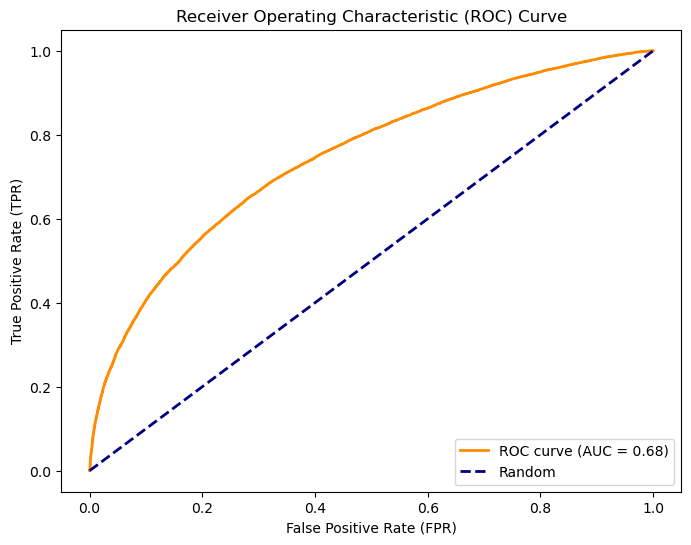

In [45]:
# Obtain Probability Scores
y_scores = model.predict_proba(X_test_LR)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_LR, y_scores)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.3f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Model Explainability

In [46]:
# Finding the top 50 most important features
coefficients = model.coef_[0]
general_features = list_of_features
ngrams_features = tfidf_vec.get_feature_names_out()
feature_names = list_of_features + list(ngrams_features)

feature_importance = list(sorted(zip(coefficients, feature_names), key=lambda x: abs(x[0]), reverse=True))[:50]

top_features = [feature for _, feature in feature_importance]
top_features

['comment_stopword_count',
 'comment_unique_word_count',
 'obviously',
 'comment_unique_token_count',
 'clearly',
 'totally',
 'duh',
 'yeah',
 'dare',
 'good thing',
 'forgot',
 'fault',
 'dropped',
 'but',
 'gee',
 'therefore',
 'shitlord',
 'everyone know',
 'must',
 'racist',
 'yea',
 'fair enough',
 'not really',
 'yes exactly',
 'parent_comment_unique_token_count',
 'amirite',
 'sexist',
 'pfft',
 'iirc',
 'commie',
 'yes let',
 'omg',
 'curious',
 'parent_comment_stopword_count',
 'pleb',
 'parent_comment_mean_token_length',
 'not wait',
 'would never',
 'although',
 'cuz',
 'yes sure',
 'psh',
 'not possibly',
 'woman',
 'not count',
 'surely',
 'shocked',
 'not like',
 'yeah fuck',
 'rigged']

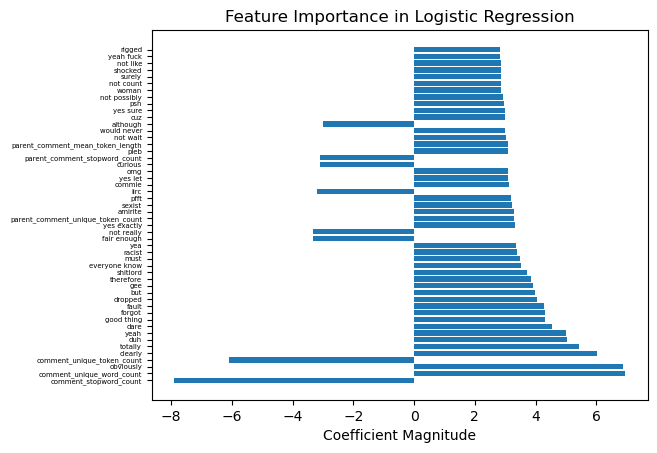

In [48]:
# Plot top 50 most important features 
importance, features = zip(*feature_importance)
plt.barh(features, importance)
plt.xlabel('Coefficient Magnitude')
plt.title('Feature Importance in Logistic Regression')
plt.yticks(fontsize=5)
plt.show()

### 4. Hyper Parameter Tuning with Grid Search CV

Baseline 5: General Features + TF-IDF has the highest mean roc_auc score. This means that it is the best performing classifier. We will now perform hyperparameter tuning on this to increase the model performance. We will use GridSearchCV to cross validate all possible hyperparameter combinations and pick the best performing hyperparameters.

In [27]:
### Using gen features and tfidf
X_train_LR = hstack([X_train_gen_features,train_tfidf_csr])

In [28]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs'],
}

In [29]:
grid_search = GridSearchCV(LogisticRegression(max_iter=100000), param_grid, cv=5, scoring='roc_auc', verbose=4)
grid_search.fit(X_train_LR, y_train_LR)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.539 total time=   1.0s
[CV 2/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.531 total time=   0.9s
[CV 3/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.529 total time=   0.9s
[CV 4/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.530 total time=   0.8s
[CV 5/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.531 total time=   1.0s
[CV 1/5] END ...C=0.001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END ...C=0.001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END ...C=0.001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END ...C=0.001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END ...C=0.001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.613 total time=   1.4s
[CV 2/5] END C=0.001, penalty

c:\Users\dxcas\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\dxcas\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\dxcas\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dxcas\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver = 

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=100000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'lbfgs']},
             scoring='roc_auc', verbose=4)

In [30]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Best score achieved during grid search
best_score = grid_search.best_score_
print("Best Score:", best_score)

Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.7433964259952544


Here we will test out the model using the best hyperparameters.

In [31]:
# Best estimator (the fitted model with the best parameters)
best_estimator = grid_search.best_estimator_
print("Best Estimator:", best_estimator)

# Results for all parameter combinations
cv_results = grid_search.cv_results_

Best Estimator: LogisticRegression(C=1, max_iter=100000, solver='liblinear')


In [32]:
# Display CV results as a table
mean_test_scores = cv_results['mean_test_score']
std_test_scores = cv_results['std_test_score']
params = cv_results['params']

pd.set_option('display.max_colwidth',None)
results_df = pd.DataFrame({'Params':params,'Mean Score':mean_test_scores,'STD':std_test_scores})
results_df["Params"] = results_df["Params"].apply(lambda x: ', '.join([f'{key}: {value}' for key, value in x.items()]))
results_df.sort_values('STD', inplace=True)
results_df.sort_values('Mean Score', ascending=False,inplace=True)
results_df.dropna() # Na values when solver is lbfgs and penalty function is l1 since lbfgs does not support l1

#for mean_score, std_score, param in zip(mean_test_scores, std_test_scores, params):
    #print(f"Mean Score: {mean_score:.3f} (±{std_score:.3f}) for params: {param}")

,Params,Mean Score,STD
14,"C: 1, penalty: l2, solver: liblinear",0.743396,0.001782
15,"C: 1, penalty: l2, solver: lbfgs",0.743394,0.001781
12,"C: 1, penalty: l1, solver: liblinear",0.739919,0.001503
11,"C: 0.1, penalty: l2, solver: lbfgs",0.728157,0.001095
10,"C: 0.1, penalty: l2, solver: liblinear",0.728151,0.001097
18,"C: 10, penalty: l2, solver: liblinear",0.721500,0.001953
19,"C: 10, penalty: l2, solver: lbfgs",0.721498,0.001953
16,"C: 10, penalty: l1, solver: liblinear",0.698818,0.002092
8,"C: 0.1, penalty: l1, solver: liblinear",0.695885,0.001116
23,"C: 100, penalty: l2, solver: lbfgs",0.685151,0.002316


Evaluating Optimized Model on Test Set

In [33]:
# Evaluate AUC_ROC
X_test_LR = hstack([X_test_gen_features,test_tfidf_csr])
y_pred_test = best_estimator.predict(X_test_LR)
roc_auc_test = roc_auc_score(y_test_LR, y_pred_test)
print(f"roc_auc test: {roc_auc_test}")

roc_auc test: 0.6836356381138846


ROC Curve on Test Set

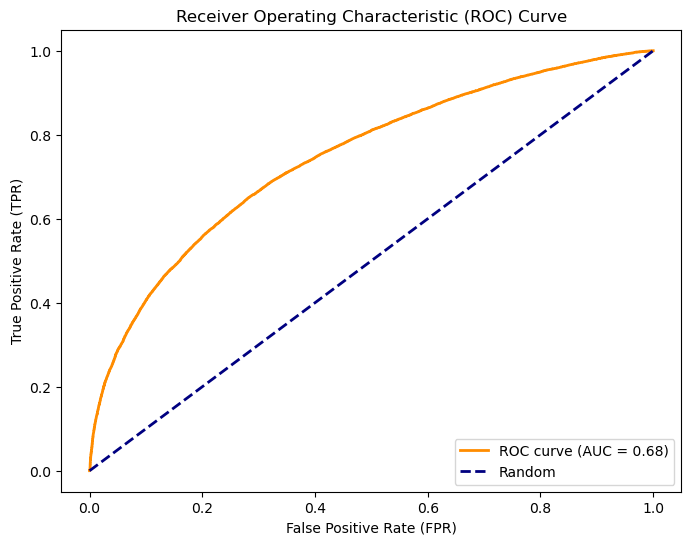

In [34]:
# Obtain Probability Scores
y_scores = best_estimator.predict_proba(X_test_LR)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_LR, y_scores)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.3f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Model Explainability

In [35]:
# Finding the top 50 most important features
coefficients = best_estimator.coef_[0]
general_features = list_of_features
ngrams_features = tfidf_vec.get_feature_names_out()
feature_names = list_of_features + list(ngrams_features)

feature_importance = list(sorted(zip(coefficients, feature_names), key=lambda x: abs(x[0]), reverse=True))[:50]

top_features = [feature for _, feature in feature_importance]
top_features

['comment_stopword_count',
 'comment_unique_word_count',
 'obviously',
 'comment_unique_token_count',
 'clearly',
 'totally',
 'duh',
 'yeah',
 'dare',
 'good thing',
 'forgot',
 'fault',
 'dropped',
 'but',
 'gee',
 'therefore',
 'shitlord',
 'everyone know',
 'must',
 'racist',
 'yea',
 'fair enough',
 'not really',
 'yes exactly',
 'parent_comment_unique_token_count',
 'amirite',
 'sexist',
 'pfft',
 'iirc',
 'commie',
 'yes let',
 'omg',
 'curious',
 'parent_comment_stopword_count',
 'pleb',
 'parent_comment_mean_token_length',
 'not wait',
 'would never',
 'although',
 'cuz',
 'yes sure',
 'psh',
 'not possibly',
 'woman',
 'not count',
 'surely',
 'shocked',
 'not like',
 'yeah fuck',
 'rigged']

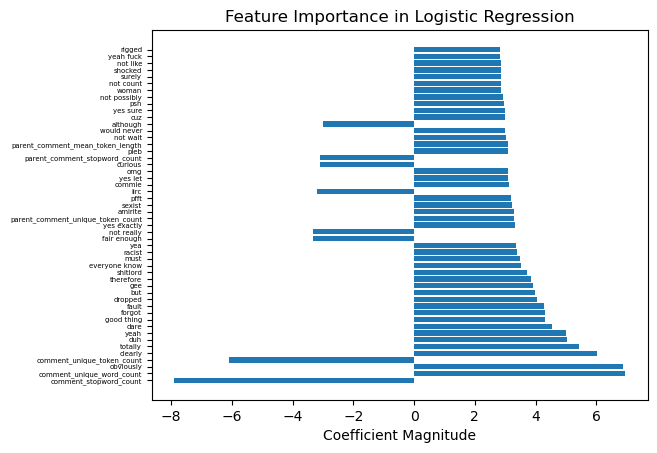

In [38]:
# Plot top 50 most important features 
importance, features = zip(*feature_importance)
plt.barh(features, importance)
plt.xlabel('Coefficient Magnitude')
plt.title('Feature Importance in Logistic Regression')
plt.yticks(fontsize=5)
plt.show()